# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import sys, os

import model
from utils import plot_images
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

from tqdm import tqdm

from create_data_loader import create_train_data_loader, create_test_data_loader
from loss_calc import train_data_accuracy, test_data_accuracy, plot_losses

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random

In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# # Train Phase transformations

train_transforms = transforms.Compose([
                                      #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       #transforms.Resize((28, 28)),
                                       transforms.RandomAutocontrast(p=0.1),
                                       transforms.RandomRotation((-7., 7.), fill=1),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])
                            
        
# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                       ])


# Test Phase transformations
inv_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                                                            std=[1/0.229, 1/0.224, 1/0.255]),
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
print (train)
print (test)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAutocontrast(p=0.1)
               RandomRotation(degrees=[-7.0, 7.0], interpolation=nearest, expand=False, fill=1)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [6]:
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = create_train_data_loader(train, **dataloader_args)
test_loader = create_test_data_loader(test, **dataloader_args)

print (len(train_loader))
print (len(test_loader))

782
157


TRAIN DATASET


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

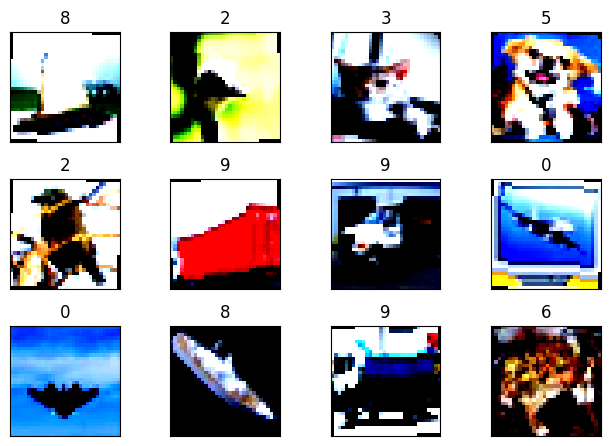

In [7]:
print ("TRAIN DATASET")
batch_data_train, batch_label_train = next(iter(train_loader))
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("train_dataset.jpg")

TEST DATATEST


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

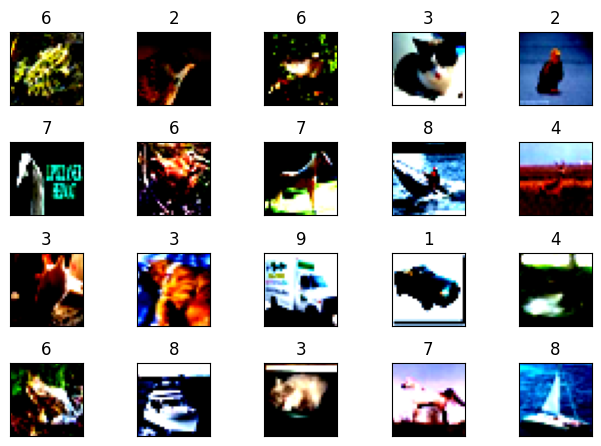

In [8]:
print ('TEST DATATEST')
batch_data_test, batch_label_test = next(iter(test_loader))
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_train.savefig("test_dataset.jpg")

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

# Model Params for Batch Normalization
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
m = model.Net_batch_normalization().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
              ReLU-2           [-1, 48, 32, 32]               0
       BatchNorm2d-3           [-1, 48, 32, 32]              96
         Dropout2d-4           [-1, 48, 32, 32]               0
            Conv2d-5           [-1, 48, 32, 32]          20,784
              ReLU-6           [-1, 48, 32, 32]               0
       BatchNorm2d-7           [-1, 48, 32, 32]              96
         Dropout2d-8           [-1, 48, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,568
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
        Dropout2d-14           [-1, 32,

In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, train_losses, train_acc):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        correct, processed, loss, pred = train_data_accuracy(processed, model, device, optimizer, data,target, epoch, train_losses, train_acc, correct)
        train_acc.append(100*correct/processed)
        
    print (" TRAIN ACCURACY: ",100*correct/processed, "TRAIN LOSS: ", loss)
    
    
def test(model, device, test_loader, test_losses, test_acc, epoch, EPOCHS):
    model.eval()
    test_loss = 0
    correct = 0
    count = 0
    with torch.no_grad():
        miss_classified_image = [[],[],[]]
        for data, target in test_loader:
            test_loss, correct, pred, test = test_data_accuracy(model, device, data,target, test_acc, test_loss, correct)
            if (epoch == EPOCHS-1):
                for i in range(0,len(pred)):
                    #print (pred[i][0],test[i])
                    if (pred[i][0]!=test[i]):
                        #print (data[i])
                        #imshow(data[i])
                        miss_classified_image[0].append(pred[i][0])
                        miss_classified_image[1].append(test[i])
                        miss_classified_image[2].append(data[i])
        
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print (" TEST ACCURACY: ",100*correct/len(test_loader.dataset), "TEST LOSS: ", test_loss)
    
    return miss_classified_image
    

In [12]:
optimizer = optim.SGD(m.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1, verbose=False)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch),
    train(m, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    miss_classified_image = test(m, device, test_loader, test_losses, test_acc, epoch, EPOCHS)

EPOCH: 0


100% 782/782 [00:04<00:00, 172.44it/s]

 TRAIN ACCURACY:  42.804 TRAIN LOSS:  1.4096099138259888


 TEST ACCURACY:  54.22 TEST LOSS:  1.2514680030822753
EPOCH: 1


100% 782/782 [00:03<00:00, 196.15it/s]

 TRAIN ACCURACY:  56.634 TRAIN LOSS:  1.456864595413208


 TEST ACCURACY:  57.28 TEST LOSS:  1.1626490610122682
EPOCH: 2


100% 782/782 [00:03<00:00, 196.75it/s]

 TRAIN ACCURACY:  62.446 TRAIN LOSS:  1.3121012449264526


 TEST ACCURACY:  66.04 TEST LOSS:  0.9445778603553772
EPOCH: 3


100% 782/782 [00:03<00:00, 201.16it/s]

 TRAIN ACCURACY:  65.776 TRAIN LOSS:  1.1331441402435303


 TEST ACCURACY:  66.25 TEST LOSS:  0.9535060393333435
EPOCH: 4


100% 782/782 [00:03<00:00, 200.74it/s]

 TRAIN ACCURACY:  70.406 TRAIN LOSS:  1.1416007280349731


 TEST ACCURACY:  72.71 TEST LOSS:  0.7677641721725463
EPOCH: 5


100% 782/782 [00:04<00:00, 191.96it/s]

 TRAIN ACCURACY:  71.456 TRAIN LOSS:  1.1869983673095703


 TEST ACCURACY:  72.84 TEST LOSS:  0.7579103002548218
EPOCH: 6


100% 782/782 [00:03<00:00, 198.37it/s]

 TRAIN ACCURACY:  71.71 TRAIN LOSS:  0.5048644542694092


 TEST ACCURACY:  72.85 TEST LOSS:  0.7506804012298584
EPOCH: 7


100% 782/782 [00:03<00:00, 198.52it/s]

 TRAIN ACCURACY:  72.048 TRAIN LOSS:  0.623291015625


 TEST ACCURACY:  73.37 TEST LOSS:  0.743765891456604
EPOCH: 8


100% 782/782 [00:03<00:00, 200.27it/s]

 TRAIN ACCURACY:  72.602 TRAIN LOSS:  0.4749578535556793


 TEST ACCURACY:  73.97 TEST LOSS:  0.7328675527572632
EPOCH: 9


100% 782/782 [00:03<00:00, 199.07it/s]

 TRAIN ACCURACY:  72.77 TRAIN LOSS:  1.28368079662323


 TEST ACCURACY:  73.94 TEST LOSS:  0.731448898935318
EPOCH: 10


100% 782/782 [00:03<00:00, 199.12it/s]

 TRAIN ACCURACY:  72.998 TRAIN LOSS:  0.44791772961616516


 TEST ACCURACY:  73.86 TEST LOSS:  0.7287748649597168
EPOCH: 11


100% 782/782 [00:03<00:00, 199.17it/s]

 TRAIN ACCURACY:  72.708 TRAIN LOSS:  0.6598883271217346


 TEST ACCURACY:  73.88 TEST LOSS:  0.7291844990730285
EPOCH: 12


100% 782/782 [00:03<00:00, 199.67it/s]


 TRAIN ACCURACY:  72.768 TRAIN LOSS:  0.8610941171646118
 TEST ACCURACY:  73.88 TEST LOSS:  0.7266203134059906
EPOCH: 13


100% 782/782 [00:03<00:00, 199.55it/s]

 TRAIN ACCURACY:  73.026 TRAIN LOSS:  0.7324104905128479


 TEST ACCURACY:  74.02 TEST LOSS:  0.7263332671165467
EPOCH: 14


100% 782/782 [00:03<00:00, 197.65it/s]

 TRAIN ACCURACY:  72.95 TRAIN LOSS:  0.8514631390571594


 TEST ACCURACY:  73.59 TEST LOSS:  0.7297554909229279
EPOCH: 15


100% 782/782 [00:04<00:00, 191.68it/s]

 TRAIN ACCURACY:  72.852 TRAIN LOSS:  1.0565149784088135


 TEST ACCURACY:  73.96 TEST LOSS:  0.7272858817100525
EPOCH: 16


100% 782/782 [00:03<00:00, 198.41it/s]

 TRAIN ACCURACY:  73.008 TRAIN LOSS:  0.5625526905059814


 TEST ACCURACY:  73.94 TEST LOSS:  0.7271017448425293
EPOCH: 17


100% 782/782 [00:03<00:00, 200.09it/s]

 TRAIN ACCURACY:  72.832 TRAIN LOSS:  0.922002911567688


 TEST ACCURACY:  74.05 TEST LOSS:  0.7267523495197297
EPOCH: 18


100% 782/782 [00:03<00:00, 197.27it/s]

 TRAIN ACCURACY:  73.12 TRAIN LOSS:  0.371884822845459


 TEST ACCURACY:  73.61 TEST LOSS:  0.7307224054336547
EPOCH: 19


100% 782/782 [00:03<00:00, 196.70it/s]

 TRAIN ACCURACY:  72.998 TRAIN LOSS:  0.8360781669616699


 TEST ACCURACY:  73.85 TEST LOSS:  0.7264380748748779


# Let's Train and test our model

This time let's add a scheduler for out LR.

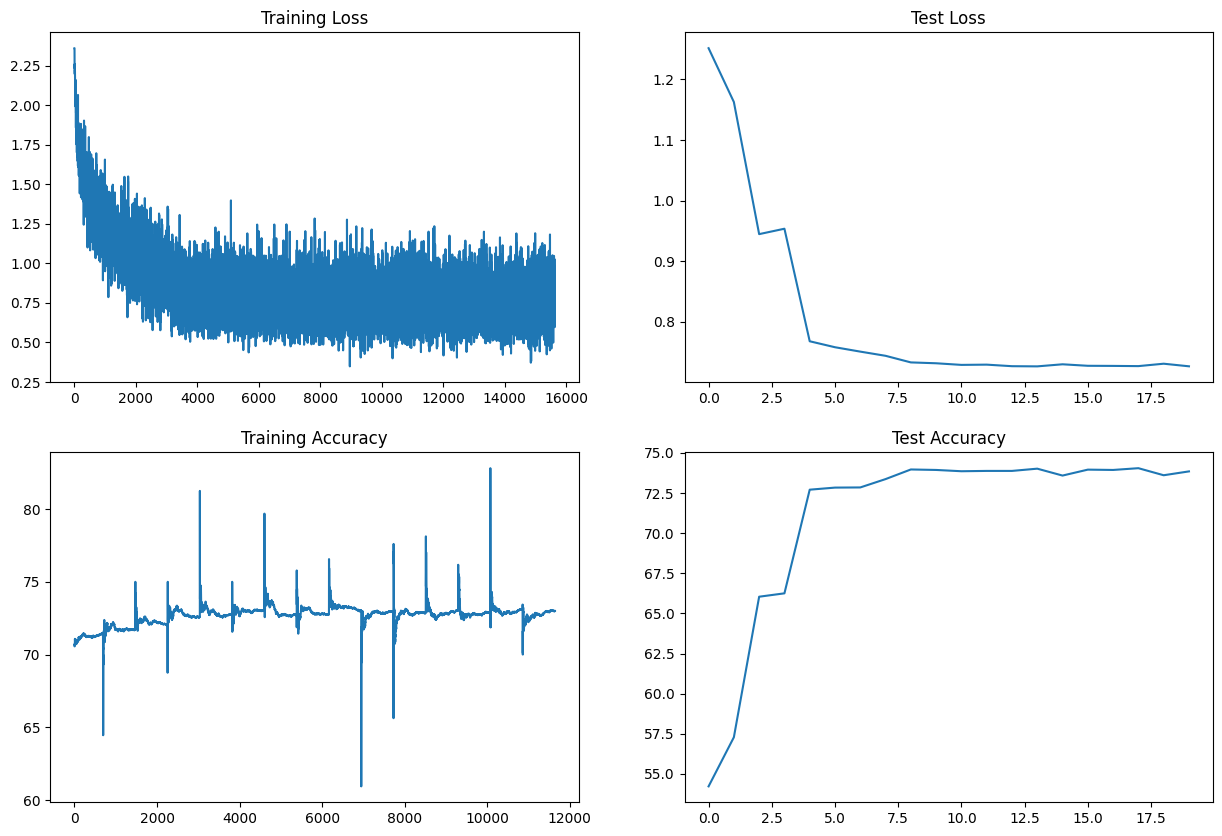

In [13]:
plot_losses(train_losses, train_acc, test_losses, test_acc, "batch_norm")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

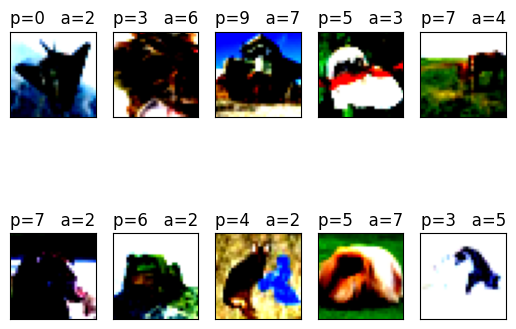

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

random_images = range(0,len(miss_classified_image[0]))
random_selects = random.sample(random_images, 10)

fig = plt.figure()
count=0
for i in random_selects:
    plt.subplot(2,5,count+1)
    plt.imshow(miss_classified_image[2][i].permute(1,2,0))   
    plt.title("p="+str(miss_classified_image[1][i])+"   "+"a="+str(miss_classified_image[0][i]))
    plt.xticks([])
    plt.yticks([])
    count+=1
plt.show()
fig.savefig("mis_classified_image.jpg")

**********************************************************

# Model Params for Group Normalization
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [16]:
m = model.Net_group_norm().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
              ReLU-2           [-1, 48, 32, 32]               0
         GroupNorm-3           [-1, 48, 32, 32]              96
         Dropout2d-4           [-1, 48, 32, 32]               0
            Conv2d-5           [-1, 48, 32, 32]          20,784
              ReLU-6           [-1, 48, 32, 32]               0
         GroupNorm-7           [-1, 48, 32, 32]              96
         Dropout2d-8           [-1, 48, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,568
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
        Dropout2d-14           [-1, 32,

In [17]:
optimizer = optim.SGD(m.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1, verbose=False)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(m, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    miss_classified_image =test(m, device, test_loader, test_losses, test_acc, epoch, EPOCHS)

EPOCH: 0


100% 782/782 [00:04<00:00, 192.29it/s]

 TRAIN ACCURACY:  35.58 TRAIN LOSS:  0.9845415353775024


 TEST ACCURACY:  50.32 TEST LOSS:  1.3896257135391235
EPOCH: 1


100% 782/782 [00:04<00:00, 195.42it/s]

 TRAIN ACCURACY:  52.618 TRAIN LOSS:  1.5675888061523438


 TEST ACCURACY:  59.9 TEST LOSS:  1.1140434240341186
EPOCH: 2


100% 782/782 [00:04<00:00, 193.72it/s]

 TRAIN ACCURACY:  58.832 TRAIN LOSS:  0.7578779458999634


 TEST ACCURACY:  60.3 TEST LOSS:  1.0808691621780395
EPOCH: 3


100% 782/782 [00:04<00:00, 192.17it/s]

 TRAIN ACCURACY:  62.706 TRAIN LOSS:  0.43251296877861023


 TEST ACCURACY:  64.85 TEST LOSS:  0.9766105565071106
EPOCH: 4


100% 782/782 [00:03<00:00, 196.13it/s]

 TRAIN ACCURACY:  68.228 TRAIN LOSS:  0.440812885761261


 TEST ACCURACY:  68.83 TEST LOSS:  0.8720150309562683
EPOCH: 5


100% 782/782 [00:04<00:00, 187.84it/s]

 TRAIN ACCURACY:  69.18 TRAIN LOSS:  0.5056551694869995


 TEST ACCURACY:  69.73 TEST LOSS:  0.8548749516487122
EPOCH: 6


100% 782/782 [00:04<00:00, 191.69it/s]

 TRAIN ACCURACY:  69.816 TRAIN LOSS:  0.7955532073974609


 TEST ACCURACY:  70.26 TEST LOSS:  0.8389356227874756
EPOCH: 7


100% 782/782 [00:04<00:00, 194.04it/s]

 TRAIN ACCURACY:  70.116 TRAIN LOSS:  1.1010968685150146


 TEST ACCURACY:  70.63 TEST LOSS:  0.8272440504074097
EPOCH: 8


100% 782/782 [00:04<00:00, 189.57it/s]

 TRAIN ACCURACY:  71.034 TRAIN LOSS:  0.9364075660705566


 TEST ACCURACY:  70.94 TEST LOSS:  0.8219367582321166
EPOCH: 9


100% 782/782 [00:04<00:00, 191.02it/s]

 TRAIN ACCURACY:  71.298 TRAIN LOSS:  0.5717273354530334


 TEST ACCURACY:  71.05 TEST LOSS:  0.8211247823238372
EPOCH: 10


100% 782/782 [00:04<00:00, 183.05it/s]

 TRAIN ACCURACY:  71.21 TRAIN LOSS:  0.8040504455566406


 TEST ACCURACY:  71.09 TEST LOSS:  0.8182879705429077
EPOCH: 11


100% 782/782 [00:04<00:00, 195.08it/s]

 TRAIN ACCURACY:  71.468 TRAIN LOSS:  0.7211886644363403


 TEST ACCURACY:  71.16 TEST LOSS:  0.8177684264183045
EPOCH: 12


100% 782/782 [00:04<00:00, 187.31it/s]

 TRAIN ACCURACY:  71.622 TRAIN LOSS:  0.9525942802429199


 TEST ACCURACY:  71.1 TEST LOSS:  0.8174503211975097
EPOCH: 13


100% 782/782 [00:04<00:00, 191.83it/s]

 TRAIN ACCURACY:  71.396 TRAIN LOSS:  0.9773470759391785


 TEST ACCURACY:  71.16 TEST LOSS:  0.8170248426437378
EPOCH: 14


100% 782/782 [00:04<00:00, 189.35it/s]

 TRAIN ACCURACY:  71.318 TRAIN LOSS:  0.6618528962135315


 TEST ACCURACY:  71.23 TEST LOSS:  0.8169645126342774
EPOCH: 15


100% 782/782 [00:04<00:00, 192.20it/s]

 TRAIN ACCURACY:  71.68 TRAIN LOSS:  0.6728267073631287


 TEST ACCURACY:  71.22 TEST LOSS:  0.8166435942649841
EPOCH: 16


100% 782/782 [00:04<00:00, 187.66it/s]

 TRAIN ACCURACY:  71.488 TRAIN LOSS:  0.7340273857116699


 TEST ACCURACY:  71.24 TEST LOSS:  0.8166477606773377
EPOCH: 17


100% 782/782 [00:04<00:00, 194.27it/s]

 TRAIN ACCURACY:  71.336 TRAIN LOSS:  1.1106921434402466


 TEST ACCURACY:  71.23 TEST LOSS:  0.8166630796432495
EPOCH: 18


100% 782/782 [00:04<00:00, 184.35it/s]

 TRAIN ACCURACY:  71.592 TRAIN LOSS:  0.49970924854278564


 TEST ACCURACY:  71.23 TEST LOSS:  0.8166431289672852
EPOCH: 19


100% 782/782 [00:04<00:00, 190.07it/s]

 TRAIN ACCURACY:  71.476 TRAIN LOSS:  0.6225221753120422


 TEST ACCURACY:  71.2 TEST LOSS:  0.816646524143219


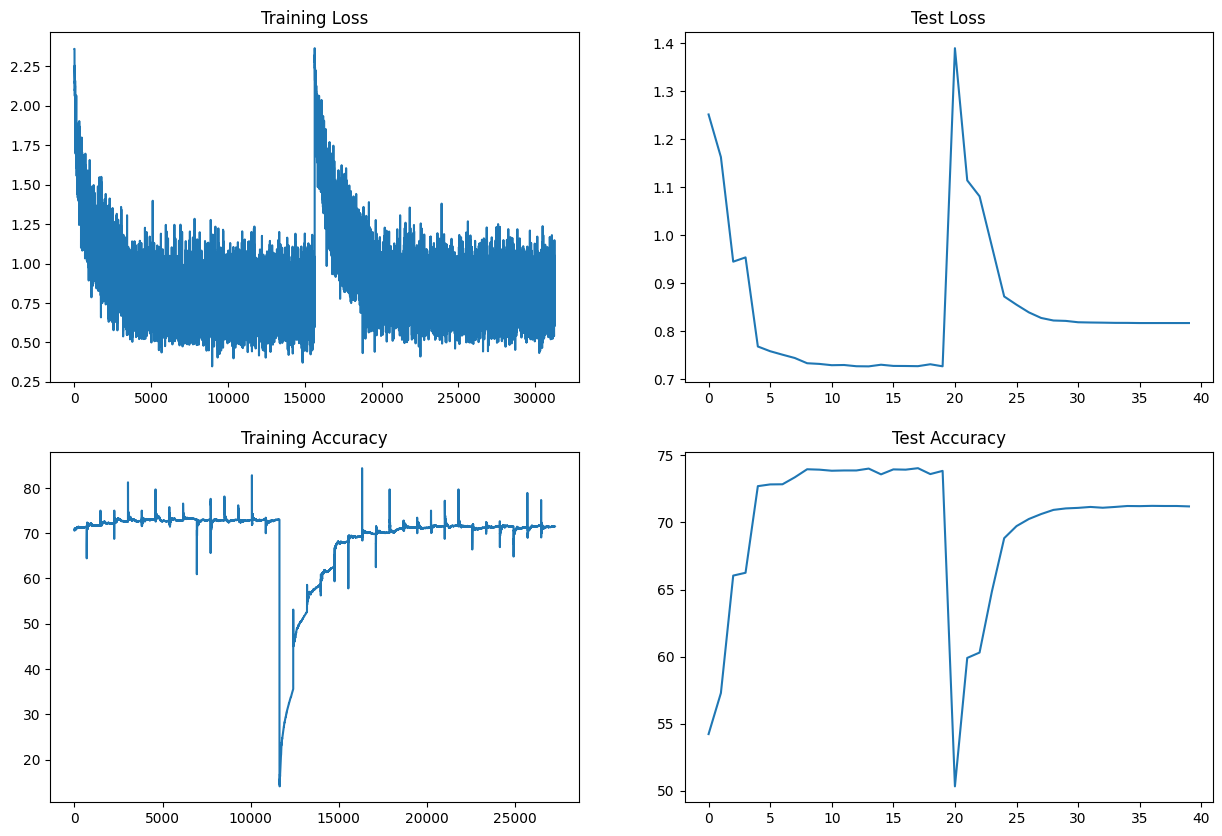

In [18]:
plot_losses(train_losses, train_acc, test_losses, test_acc, "group_norm")

# Model Params for Layer Normalization
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [19]:
m = model.Net_layer_normalization().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             280
              ReLU-2           [-1, 10, 32, 32]               0
         LayerNorm-3           [-1, 10, 32, 32]          20,480
         Dropout2d-4           [-1, 10, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             728
              ReLU-6            [-1, 8, 32, 32]               0
         LayerNorm-7            [-1, 8, 32, 32]          16,384
         Dropout2d-8            [-1, 8, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             144
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11            [-1, 8, 16, 16]           1,160
             ReLU-12            [-1, 8, 16, 16]               0
        LayerNorm-13            [-1, 8, 16, 16]           4,096
        Dropout2d-14            [-1, 8,

In [20]:
optimizer = optim.SGD(m.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1, verbose=False)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(m, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    miss_classified_image =test(m, device, test_loader, test_losses, test_acc,epoch, EPOCHS)

EPOCH: 0


100% 782/782 [00:04<00:00, 164.13it/s]

 TRAIN ACCURACY:  27.536 TRAIN LOSS:  1.635741949081421


 TEST ACCURACY:  36.04 TEST LOSS:  1.6507421562194824
EPOCH: 1


100% 782/782 [00:04<00:00, 185.88it/s]

 TRAIN ACCURACY:  38.446 TRAIN LOSS:  1.4738911390304565


 TEST ACCURACY:  42.37 TEST LOSS:  1.5063027648925782
EPOCH: 2


100% 782/782 [00:04<00:00, 187.05it/s]

 TRAIN ACCURACY:  44.192 TRAIN LOSS:  1.8348366022109985


 TEST ACCURACY:  47.03 TEST LOSS:  1.3981597969055175
EPOCH: 3


100% 782/782 [00:04<00:00, 177.10it/s]

 TRAIN ACCURACY:  47.262 TRAIN LOSS:  1.6799182891845703


 TEST ACCURACY:  50.93 TEST LOSS:  1.3129550395965577
EPOCH: 4


100% 782/782 [00:04<00:00, 191.87it/s]

 TRAIN ACCURACY:  51.338 TRAIN LOSS:  0.6261267066001892


 TEST ACCURACY:  52.67 TEST LOSS:  1.2678086074829102
EPOCH: 5


100% 782/782 [00:04<00:00, 188.08it/s]

 TRAIN ACCURACY:  51.648 TRAIN LOSS:  1.893672227859497


 TEST ACCURACY:  52.82 TEST LOSS:  1.260788454246521
EPOCH: 6


100% 782/782 [00:04<00:00, 190.44it/s]

 TRAIN ACCURACY:  51.85 TRAIN LOSS:  1.6308934688568115


 TEST ACCURACY:  53.34 TEST LOSS:  1.2514771827697755
EPOCH: 7


100% 782/782 [00:04<00:00, 187.48it/s]

 TRAIN ACCURACY:  52.252 TRAIN LOSS:  1.1268935203552246


 TEST ACCURACY:  53.23 TEST LOSS:  1.2499142184257508
EPOCH: 8


100% 782/782 [00:04<00:00, 190.55it/s]

 TRAIN ACCURACY:  52.806 TRAIN LOSS:  1.5781320333480835


 TEST ACCURACY:  53.75 TEST LOSS:  1.2405123386383057
EPOCH: 9


100% 782/782 [00:04<00:00, 186.88it/s]

 TRAIN ACCURACY:  52.566 TRAIN LOSS:  1.5402023792266846


 TEST ACCURACY:  53.78 TEST LOSS:  1.238077147102356
EPOCH: 10


100% 782/782 [00:04<00:00, 186.20it/s]

 TRAIN ACCURACY:  52.71 TRAIN LOSS:  1.3233413696289062


 TEST ACCURACY:  53.78 TEST LOSS:  1.237330093574524
EPOCH: 11


100% 782/782 [00:04<00:00, 188.73it/s]

 TRAIN ACCURACY:  52.748 TRAIN LOSS:  1.6194740533828735


 TEST ACCURACY:  53.83 TEST LOSS:  1.2366361436843871
EPOCH: 12


100% 782/782 [00:04<00:00, 177.67it/s]

 TRAIN ACCURACY:  52.948 TRAIN LOSS:  0.967087984085083


 TEST ACCURACY:  53.85 TEST LOSS:  1.236133126449585
EPOCH: 13


100% 782/782 [00:04<00:00, 186.71it/s]

 TRAIN ACCURACY:  53.006 TRAIN LOSS:  1.7324563264846802


 TEST ACCURACY:  53.88 TEST LOSS:  1.235897011566162
EPOCH: 14


100% 782/782 [00:04<00:00, 181.25it/s]

 TRAIN ACCURACY:  52.842 TRAIN LOSS:  1.4016448259353638


 TEST ACCURACY:  53.86 TEST LOSS:  1.2360771013259888
EPOCH: 15


100% 782/782 [00:04<00:00, 180.56it/s]

 TRAIN ACCURACY:  52.794 TRAIN LOSS:  1.2241156101226807


 TEST ACCURACY:  53.91 TEST LOSS:  1.2360064319610595
EPOCH: 16


100% 782/782 [00:04<00:00, 179.83it/s]

 TRAIN ACCURACY:  52.992 TRAIN LOSS:  1.35785973072052


 TEST ACCURACY:  53.92 TEST LOSS:  1.2359877223968505
EPOCH: 17


100% 782/782 [00:04<00:00, 176.30it/s]

 TRAIN ACCURACY:  52.878 TRAIN LOSS:  1.2788848876953125


 TEST ACCURACY:  53.9 TEST LOSS:  1.2359786205291747
EPOCH: 18


100% 782/782 [00:04<00:00, 177.11it/s]

 TRAIN ACCURACY:  52.996 TRAIN LOSS:  1.0128363370895386


 TEST ACCURACY:  53.9 TEST LOSS:  1.2359429239273072
EPOCH: 19


100% 782/782 [00:04<00:00, 186.01it/s]

 TRAIN ACCURACY:  53.106 TRAIN LOSS:  1.1854411363601685


 TEST ACCURACY:  53.9 TEST LOSS:  1.2359205146789551


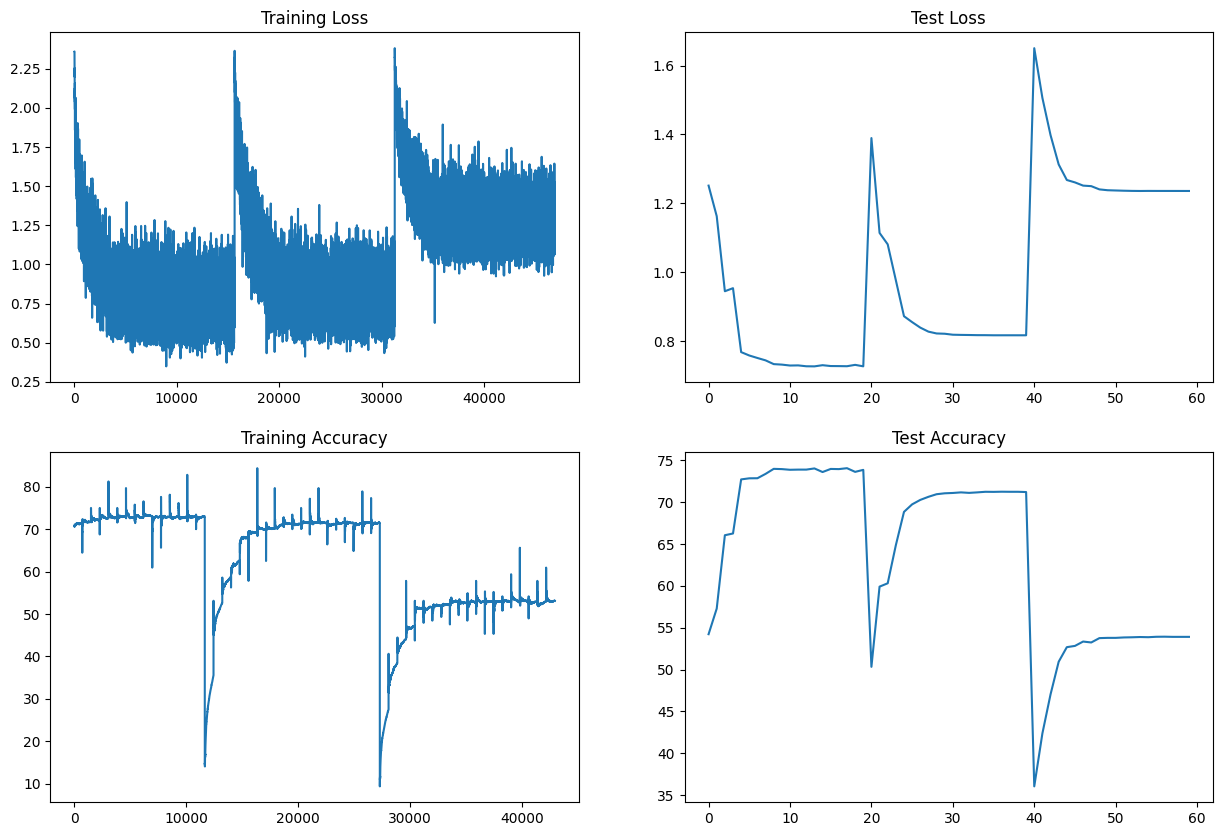

In [21]:
plot_losses(train_losses, train_acc, test_losses, test_acc, "Layer_norm")